In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import bz2
%matplotlib inline

merged = pd.read_csv("./merged.txt" )

df = merged['orbit']

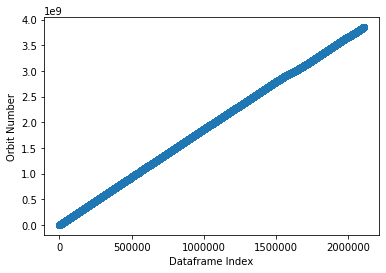

In [2]:
plt.scatter([i for i in range(len(df))],df) 
plt.xlabel('Dataframe Index')
plt.ylabel('Orbit Number')
plt.show()

In [3]:
# for each orbit, we dump in the CSV 110 BX's (= bxMax - bxMin) that 'sit' in the LHC abort gap (end of the train)
# that is, each orbit in the CSV corresponds to 110*24.95 ns of active recorded time, due to our selection made 
# (we dump in CSV only a part of each orbit during the LHC abort gap)
timePerOrbit = 110*24.95
print('timePerOrbit %2.1f ns '%timePerOrbit)

timeUnit = 0.2*1e9 # desired time unit in seconds
orbitsPerTimeUnit = timeUnit/timePerOrbit
print('orbitsPerTimeUnit = %2.3f'%orbitsPerTimeUnit)





orbitMin  = df[:1].values[0]
orbitMax  = df[-1:].values[0] 
rectime   = (orbitMax-orbitMin)*timePerOrbit # in ns
print('orbitMin %d orbitMax %d'%(orbitMin, orbitMax))
print('nOrbits %d '%(orbitMax - orbitMin))
print('total recording time %2.4f ns (~= %2.1f s)' %(rectime, rectime*1.e-9))

bins=int((orbitMax-orbitMin)/orbitsPerTimeUnit) 
print("bins = %d" %bins)
timePerBin = rectime/bins

timePerOrbit 2744.5 ns 
orbitsPerTimeUnit = 72873.019
orbitMin 1 orbitMax 3851535892
nOrbits 3851535891 
total recording time 10570540252849.5000 ns (~= 10570.5 s)
bins = 52852


In [4]:
muons=np.zeros(bins)
sclice=np.array([orbitMin+ ((orbitMax-orbitMin)/bins)*i for i in range(bins+1)])

# Count the events in the first orbit = orbitMin
for orbit in df:
    if(orbit > orbitMin): break
    if(orbit == orbitMin): muons[0] += 1
        
df = df[int(muons[0]):] # We already counted the first orbit
i = 0
for orbit in df:
    while not (orbit > sclice[i] and orbit <= sclice[i + 1]) and i < bins-1: # Note the <= in 'orbit <= slicePlusOne[i]'. 
        i = i + 1                                                              # It is needed to capture the last orbit.
    muons[i] += 1

In [5]:
np.savetxt('muons.txt', muons, fmt =' %d ') # so that someone else can intstant access to the data without running this code

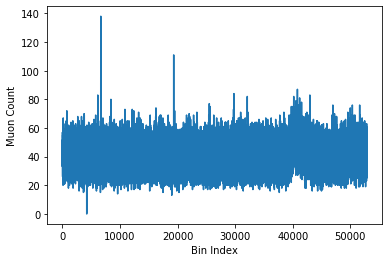

In [6]:
plt.plot([i for i in range(len(muons))], muons)
plt.xlabel('Bin Index')
plt.ylabel('Muon Count')
plt.show()

In [7]:
Nmuons = int(muons.sum()) 
Ncounts = len(muons) # How many time intervals

mu = muons.mean()
med = np.median(muons)
sigma = muons.std()
MLE = Nmuons/Ncounts
print("Maximum Likelihood Estimate for Poisson parameter λ: \nMLE = {}" .format(MLE))


Maximum Likelihood Estimate for Poisson parameter λ: 
MLE = 39.903636570044654


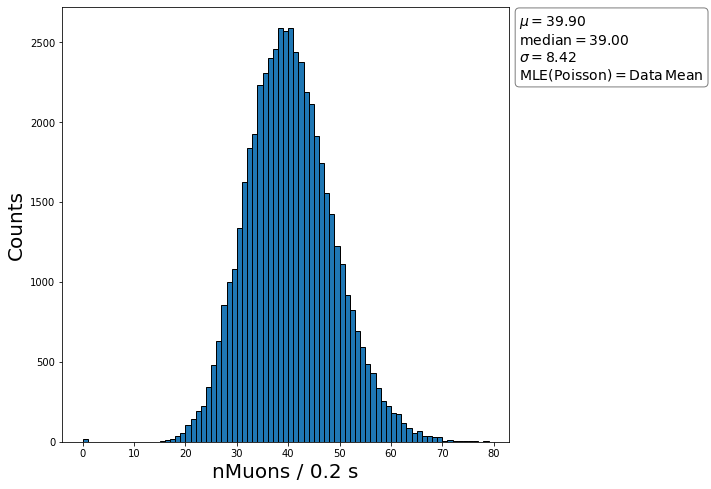

In [8]:
maxBins = 80
plt.figure(figsize=(8,8))
binCounts, bin_edges, patches = plt.hist(muons, bins= [i for i in range(maxBins)], histtype = 'bar', ec='black', density = False)
plt.xlabel('nMuons / %2.1f s'%(timePerBin*1.e-9), fontsize = 20) # latex can be entered in the label's string
plt.ylabel('Counts', fontsize = 20)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
boxtxt = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (med, ),
    r'$\sigma=%.2f$' % (sigma, ), 
    r'$\mathrm{MLE(Poisson)}=\mathrm{Data \, Mean}$'))

plt.text(85, 2270, boxtxt, fontsize=14, bbox = props)
plt.show()